In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import matplotlib.pyplot as plt
from typing import Callable
from functools import partial

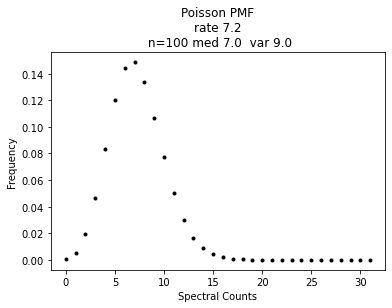

In [2]:
pmf = jsp.stats.poisson.pmf

x = np.arange(0, 32)
lamb = 7.2
y = pmf(x, lamb)

title = f"Poisson PMF\nrate {lamb}"
plt.plot(x, y, 'k.')
plt.xlabel('Spectral Counts')
plt.ylabel('Frequency')


# Generate random samples
key = jax.random.PRNGKey(113)
n = 100
samples = jax.random.poisson(key, lamb, [n])

med = np.median(samples)
med = np.round(med)
var = np.var(samples)
var = np.round(var)

title += f'\n n={n} med {med}  var {var}'
plt.title(title)
plt.show()

In [3]:
def slice_sweep__s(key, x: float, pstar: Callable, w: float) -> Callable:
    """Univariate Slice Sampling
    
    (x, u) -> (x', u')
    Maps a point x, u under the density function pstar to x' u'
    
    Folowing David MacKay Book

    Advantages:

    No need for tuning (opposed to Metropolis). src wikipedia
    Automatically adjusts the step size to match the local shape
    of the density function.
    Easier to implement than gibbs.
  
    Random variates exhibit seriel statistical dependance.
  
    For P(x) = 1/Z * P*(x)
    Thus P*(x) \propto P(x)
  
    MacKay Pseudocode
  
    1. evaluate P*(x)
    2. draw a vertical coordinate u' ~ Unmiform(0, P*(x))
    3. create a horizontal interval (xl, xr) enclosing x
    4. loop {
    5.   draw x' ~ Uniform(xl, xr)
    6.   evaluate P*(x')
    7.   if P*(x') > u' break out of loop 4-9
    8.   else modify the interval (xl, xr)
    }
    
    Params:
    
      key: A jax.random.PRNGKeyArray
      x: A starting coordinate for the sweep within the domain of pstar
      pstar: A univariate (1-dimensional) probability mass or density function of one parameter.
             p(x)=1/Z*pstar(x). Thus pstar does not have to be normalized
      w: A weight parameter for the stepping our algorithm in step 3.
      
    Returns:
      x_prime, u_prim
    """
    
    k1, k2, k3, k4 = jax.random.split(key, 4)
    # step 1 evaluate pstar(x)
    u = pstar(x)
    
    # step 2 draw a vertical coordinate
    u_prime = jax.random.uniform(k1, minval=0, maxval=u)
    
    # step 3 create a horizontal interval (xl, xr) enclosing x
    r = jax.random.uniform(k2, minval=0, maxval=1)
    
    xl = x - r * w
    xr = x + (1 - r) * w
    
    xl = jax.lax.while_loop(lambda xl: pstar(xl) > u_prime, lambda xl: xl - w, xl)
    xr = jax.lax.while_loop(lambda xr: pstar(xr) > u_prime, lambda xr: xr + w, xr)
    
    # step 4 loop 1st iteration
    
    loop_break = False
    
    # step 5 draw x'
    x_prime = jax.random.uniform(k3, minval=xl, maxval=xr)
    
    # step 6 evaluate pstar(x')
    t = pstar(x_prime)
    
    
    def step7_true_func(val):
        """Do nothing break out of loop"""
        key, x, x_prime, xl, xr, u_prime, t, loop_break = val
        loop_break = True
        return key, x, x_prime, xl, xr, u_prime, t, loop_break

    def step8(val):
        """Perform the shrinking method for step 8"""
        key, x, x_prime, xl, xr, u_prime, t, loop_break = val       
        
        x_prime, x, xr, xl = jax.lax.cond(
            x_prime > x, 
            lambda x_prime, x, xr, xl: (x_prime, x, x_prime, xl),  # reduce the right side
            lambda x_prime, x, xr, xl: (x_prime, x, xr, x_prime),  # reduce the left side
            *(x_prime, x, xr, xl))
        
        return key, x, x_prime, xl, xr, u_prime, t, loop_break
    
    def step7_and_8(val):
        val = jax.lax.cond(
            val[6] > val[5], # p*(x')>u'
            step7_true_func, # do nothing. Break out of loop
            step8, # step 8 modify the interval (xl, xr)
            val)
        
        return val

    # step 7 if pstar(x') > u' break out of loop. else modify interval
    
    val = k4, x, x_prime, xl, xr, u_prime, t, loop_break
    val = step7_and_8(val)

    def step4_loop_body(val):
        
        # step 5 draw x'
        key, x, x_prime, xl, xr, u_prime, t, loop_break = val 
        key, subkey = jax.random.split(key)
        x_prime = jax.random.uniform(subkey, minval=xl, maxval=xr)
        
        # step 6 evaluate pstar(x')
        t = pstar(x_prime)
        
        # step 7
        
        val = key, x, x_prime, xl, xr, u_prime, t, loop_break
        val = step7_and_8(val)
        return val
    
    # End 1st loop iteration
    # Continue the loop executing the while loop
    
    def while_cond_func(val):
        """Check the loop break condition,
           terminate the loop if True"""
        key, x, x_prime, xl, xr, u_prime, t, loop_break = val
        return loop_break == False
    
    val = jax.lax.while_loop(
        while_cond_func, # check the loop break condition
        step4_loop_body, 
        val) # u_prime <= p*(x') i.e., t
        
    return val

In [ ]:
w = 50
rate = 57
key = jax.random.PRNGKey(13)

pstar = partial(jsp.stats.norm.pdf, loc=rate, scale=9)
#pstar = partial(jsp.stats.poisson.pmf, mu=rate)

fa = partial(jsp.stats.norm.pdf, loc=10, scale=2)
fb = partial(jsp.stats.poisson.pmf, mu=100)

def pstar(x):
    return fa(x) + fb(x)
x=7

def pstar(x):
    return 0.

slice_sweep = partial(slice_sweep__s,
                     pstar=pstar,
                     w=w,
                     )

ss = jax.jit(slice_sweep)

def sample(key, nsamples, ss, x):
    samples = jnp.zeros(nsamples)
    for i in range(nsamples):
        key, subkey = jax.random.split(key)
        val = ss(key=subkey, x=x)
        key, x, x_prime, xl, xr, u_prime, t, loop_break = val
        x = x_prime
        samples = samples.at[i].set(x_prime)
    
    return samples



key = jax.random.PRNGKey(13)
x = 3


ss(key=key, x=x)

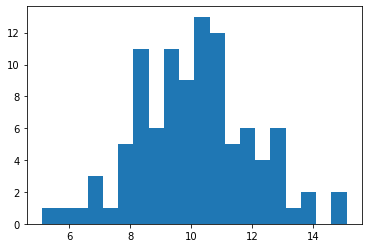

In [14]:
samples = sample(key, 100, ss, x)

samples = np.array(samples)
plt.hist(samples, bins=20)
plt.show()

In [ ]:
key = jax.random.PRNGKey(55)
x = 1000
samples = sample(key, 100, ss, x)

samples = np.array(samples)
plt.hist(samples, bins=20)
plt.show()

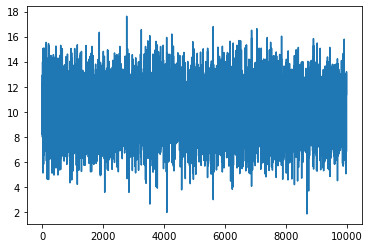

In [13]:
plt.plot(np.arange(0, len(samples), 1), samples)

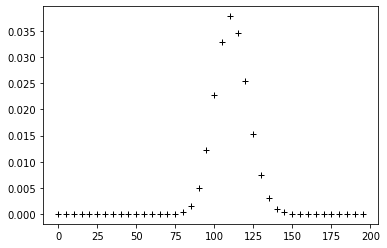

In [22]:
x = np.arange(0, 200, 5)
y = pstar(x)
x = np.array(x)
y = np.array(y)
plt.plot(x, y, 'k+')

In [18]:
y

DeviceArray([0.0000000e+00, 4.8616059e-35, 2.0589512e-26, 5.3621473e-20,
             4.9497573e-15, 3.7704138e-11, 3.9129809e-08, 7.7182194e-06,
             3.6680687e-04, 5.0170063e-03, 2.2677615e-02, 3.7836723e-02,
             2.5507245e-02, 7.4922182e-03, 1.0218829e-03, 6.8374189e-05,
             2.3526670e-06, 4.3396767e-08, 4.4513040e-10, 2.6228802e-12,
             9.1411626e-15, 1.9343177e-17, 2.5450446e-20, 2.1273291e-23,
             1.1520056e-26, 4.1163017e-30, 9.8637825e-34, 1.6104799e-37,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.000000

In [ ]:
key = jax.random.PRNGKey(13)
for i in range(40):
    key, subkey = jax.random.split(key)
    ss(key=subkey)
    

In [76]:
def body(val):
    key, r, count = val
    count += 1
    key, subkey = jax.random.split(key)
    r = jax.random.uniform(subkey)
    return key, r, count

def cond_func(val):
    key, r, count = val
    return r < 0.5

count = 0

r = 0.3
key = jax.random.PRNGKey(13)

val = key, r, count
val = jax.lax.while_loop(cond_func, body, val)

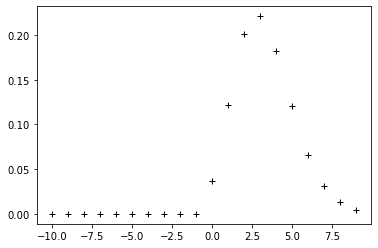

In [44]:
x = np.arange(-10, 10)
y = jsp.stats.poisson.pmf(x, 3.3)
plt.plot(x, y, 'k+')

In [86]:
def f(val):
    val = jax.lax.cond(
        val[0] > val[1], 
        lambda val: val[0],
        lambda val: val[1], 
        val)
    return val

jf = jax.jit(f)
jf((1, 2))

DeviceArray(2, dtype=int32, weak_type=True)